In [44]:
# pyqubo stuff
from pyqubo import Array, Constraint
from mpl_toolkits.mplot3d import Axes3D

import math
import matplotlib.pyplot as plt
import numpy as np
import re
import neal
import itertools

In [532]:
SQUARE_SIZE = 2
BITS = math.floor(math.log2(SQUARE_SIZE**2) + 1)
VARS = SQUARE_SIZE * SQUARE_SIZE * BITS

In [468]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## QUBO Implementation

$$S_{\text{row=i}} = \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$
$$P_{\text{row}} = \sum_{i1>i2}^{n}\left[\sum_{j=1}^{n}\sum_{k=1}^{s}x_{i2,j,k} * 2^{s-k} - \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i1,j,k} * 2^{s-k}\right]^2$$

In [469]:
def implement_row(H, variables, penalty=1):
    for row1 in range(SQUARE_SIZE):
        for row2 in range(row1, SQUARE_SIZE):
            if row1 == row2:
                continue

            print(f"Comparing row {row1} -> {row2}")

            H_row1 = 0
            H_row2 = 0

            for j in range(SQUARE_SIZE):
                H_row1 += Constraint(penalty * np.sum([list(variables)[get_index(row1,j,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{row1}_{j}")

            for j in range(SQUARE_SIZE):
                H_row2 += Constraint(penalty * np.sum([list(variables)[get_index(row2,j,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{row2}_{j}")


            H += (H_row1 - H_row2) ** 2
        
    return H
            

$$S_{\text{col=j}} = \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$
$$P_{\text{col}} = \sum_{j1>j2}^{n}\left[\sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j2,k} * 2^{s-k} - \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j1,k} * 2^{s-k}\right]^2$$

In [470]:
def implement_col(H, variables, penalty=1):
    for col1 in range(SQUARE_SIZE):
        for col2 in range(col1, SQUARE_SIZE):
            if col1 == col2:
                continue

            print(f"Comparing column {col1} -> {col2}")

            H_col1 = 0
            H_col2 = 0

            for i in range(SQUARE_SIZE):
                H_col1 += Constraint(penalty * np.sum([list(variables)[get_index(i,col1,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{i}_{col1}")

            for i in range(SQUARE_SIZE):
                H_col2 += Constraint(penalty * np.sum([list(variables)[get_index(i,col2,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{i}_{col2}")


            H += (H_col1 - H_col2) ** 2
        
    return H
            

$$\sum_{i=1}^{n}\sum_{j=1}^{n}\left[\prod_{k=1}^{s}1 - (x_{i,j,k} \oplus 0)\right]$$

In [471]:
def implement_empty(H, variables, penalty=1):

    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)

    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
                H += Constraint(penalty * np.prod([1 - xor(var, 0) for var in list(variables)[get_index(i,j,0):get_index(i,j,BITS)]]), label=f"empty_{i}_{j}")

    return H
                

$$\sum_{i1<i2}^{n}\sum_{j1<j2}^{n}\left[\prod_{k=1}^{s}{1 - (x_{i1,j1,j} \oplus x_{i2,j2,k})}\right]$$

In [499]:
def implement_unique(H, variables, penalty=1):

    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)

    for i1 in range(SQUARE_SIZE):
        for j1 in range(SQUARE_SIZE):
            for i2 in range(i1, SQUARE_SIZE):
                for j2 in range(SQUARE_SIZE):
                    if i1 == i2 and j1 <= j2:
                        continue

                    # print(f"Comparing {i1},{j1} -> {i2},{j2}")
                    H_tmp = 1

                    for k in range(BITS):
                        var1 = variables[get_index(i1,j1,k)]
                        var2 = variables[get_index(i2,j2,k)]
                        
                        H_tmp *= Constraint(1 - ((var1 + var2) - (2 * var1 * var2)), label=f"unique_{i1}_{j1}_{i2}_{j2}_{k}")

                    H += penalty * H_tmp

                    
    return H
                

In [531]:
def implement_unique_2(H, variables, penalty=1):
    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)
    
    for i1 in range(SQUARE_SIZE):
        for j1 in range(SQUARE_SIZE):
            for i2 in range(i1, SQUARE_SIZE):
                for j2 in range(SQUARE_SIZE):
                    if i1 == i2 and j2 <= j1:
                        continue

                    H_tmp = 0

                    for k in range(BITS):
                        H_tmp *= Constraint(1 - xor(variables[get_index(i1,j1,k)], variables[get_index(i2,j2,k)]), label=f"unique_{i1}_{j1}_{i2}_{j2}_{k}")

                    H +=  H_tmp

                    # or
                    # H += Constraint(np.prod([1 - xor(variables[get_index(i1,j1,k)], variables[get_index(i2,j2,k)]) for k in range(BITS)]), label=f"unique_{i1}_{j1}_{i2}_{j2}")
    return penalty * H



def implement_unique_test(square):
    total_cost = 0
    
    for i1 in range(len(square)):
        for j1 in range(len(square)):
            for i2 in range(i1, len(square)):
                for j2 in range(len(square)):
                    if i1 == i2 and j2 <= j1:
                        continue
                    
                    # get a bits representation 
                    var1_bits = list(map(int, list("%04d" % int(bin(square[i1][j1])[2:]))))
                    var2_bits = list(map(int, list("%04d" % int(bin(square[i2][j2])[2:]))))

                    tmp_cost = 1

                    for k in range(4):
                        tmp_cost *= (1 - (var1_bits[k] ^ var2_bits[k]))

                    total_cost += tmp_cost

    return total_cost

                    

implement_unique_test([[2,2,2],[4,4,6],[7,8,9]])

4

In [550]:
def penalty_unique_test(var1, var2):
    combinations = {}
    total = 0
    for i in range(len(var1)):
        for j in range(len(var1)):
            if (var1[i], var2[j]) in combinations:
                combinations[(var1[i], var2[j])] += 1
            else:
                combinations[(var1[i], var2[j])] = 1

    print(combinations)

    # now for all combinations
    for i in range(len(combinations.keys())):
        for j in range(len(combinations.keys())):
            key1 = list(combinations.keys())[i]
            key2 = list(combinations.keys())[j]

            total += (combinations[key1] - combinations[key2]) ** 2
            
            
    return total

penalty_unique_test("0101", "0110")

{('0', '0'): 4, ('0', '1'): 4, ('1', '0'): 4, ('1', '1'): 4}


0

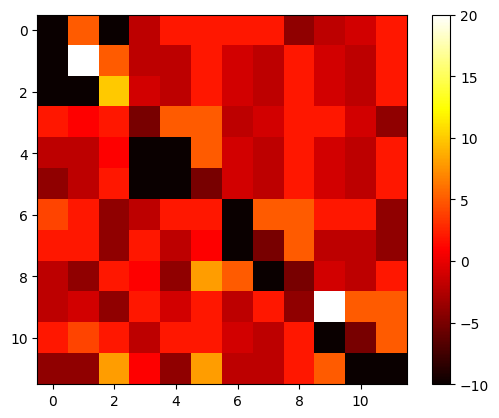

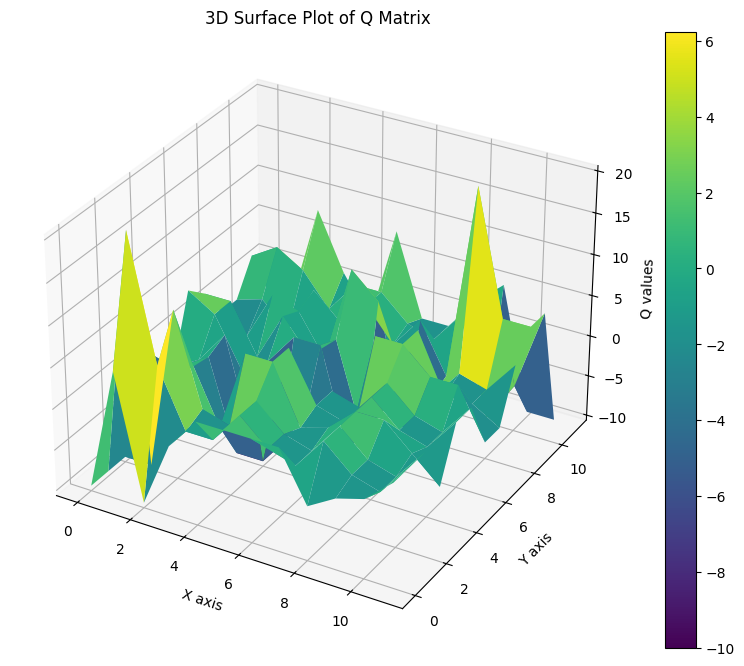

In [551]:
array = Array.create('x', VARS, 'BINARY')

# apply constraints
H = 0
H += implement_empty(H, array, 1)
H += implement_unique(H, array, 1)
# H += implement_row(H, array, 1)
# H += implement_col(H, array, 1)

model = H.compile()
qubo, offset = model.to_qubo()

Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

for key, value in qubo.items():
    i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
    j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

    Q[i][j] = value

plt.imshow(Q, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Create a meshgrid for the indices of the Q matrix
x = np.arange(Q.shape[0])
y = np.arange(Q.shape[1])
x, y = np.meshgrid(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, Q, cmap='viridis')

# Add a color bar which maps values to colors
fig.colorbar(surf)

    
# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Q values')

# Set title
ax.set_title('3D Surface Plot of Q Matrix')
# ax.view_init(elev=30, azim=90)

plt.show()

## Quantum Part

In [552]:
# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=5000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy

    # print(sample)
    
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    solutions.append({"sample": sample, "energy": energy})

In [529]:
square = np.array([[2,2,2],[4,4,6],[7,8,9]])

sample = {}
counter = 0

# encode the single variables
for num in square.flatten():

    # convert number to binary
    binary = list(map(int, list("%04d" % int(bin(num)[2:]))))

    for i, bit in enumerate(binary):
        sample.setdefault(f"x[{counter}]", bit)
        counter += 1

# now encode the multiplied variables
# for 

    
    
    # for k in range(4):

## Analyse

In [553]:
def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            
            
            if sum(item) != 0:
                index = int("".join([str(int(i)) for i in item]), 2)
                grid[i][j] = index
            else:
                grid[i][j] = -1
    return np.array(grid)


def check_binary(sample):

    # count how many samples are not binary encoded
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            if sum(sample[i][j]) == 0:
                return False
            
    # return True if all samples are one hot encoded
    return True


def check_unique(sample):
    
    # get grid
    grid = get_grid(sample)

    # test for uniqueness
    if len(set(grid.flatten())) == SQUARE_SIZE**2:
        return True
    
    return False


def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False


binary = 0
unique = 0
sumcol = 0
sumrow = 0

for solution in solutions:
    if check_binary(solution["sample"]) is True:
        binary += 1
    else:   
        continue # avoid checking for unique if the ohe is not correct

    # print(get_grid(solution["sample"]))
    
    if check_unique(solution["sample"]):
        unique += 1

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1


print(f"Binary Correct: {binary}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")

Binary Correct: 5000/5000
Unique Correct: 4113/5000
Sum Column Correct: 501/5000
Sum Row Correct: 534/5000


## Show Examples

In [554]:

def to_decimal(array):
        return int("".join([str(int(i)) for i in array]), 2)


def get_grid(sample):
    
        
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])

            
            if 1 in item:

                ## convert binary value to decimal
                grid[i][j] = to_decimal(item)
            else:
                grid[i][j] = -1
    return np.array(grid)


def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)


for key, value in condensed.items():
    print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
    print(value)
    print("\n\n")

[[1. 2.]
 [3. 4.]]
{'count': 12, 'energy': 0.0}



[[1. 2.]
 [5. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 2.]
 [6. 4.]]
{'count': 6, 'energy': 0.0}



[[1. 2.]
 [7. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 3.]
 [2. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 3.]
 [5. 4.]]
{'count': 7, 'energy': 0.0}



[[1. 3.]
 [6. 4.]]
{'count': 2, 'energy': 0.0}



[[1. 3.]
 [7. 4.]]
{'count': 8, 'energy': 0.0}



[[1. 5.]
 [2. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 5.]
 [3. 4.]]
{'count': 6, 'energy': 0.0}



[[1. 5.]
 [6. 4.]]
{'count': 7, 'energy': 0.0}



[[1. 5.]
 [7. 4.]]
{'count': 3, 'energy': 0.0}



[[1. 6.]
 [2. 4.]]
{'count': 2, 'energy': 0.0}



[[1. 6.]
 [3. 4.]]
{'count': 4, 'energy': 0.0}



[[1. 6.]
 [5. 4.]]
{'count': 6, 'energy': 0.0}



[[1. 6.]
 [7. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 7.]
 [2. 4.]]
{'count': 5, 'energy': 0.0}



[[1. 7.]
 [3. 4.]]
{'count': 8, 'energy': 0.0}



[[1. 7.]
 [5. 4.]]
{'count': 4, 'energy': 0.0}



[[1. 7.]
 [6. 4.]]
{'count': 2, 'energy': 0.0}


